In [44]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [45]:
# Load Data
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [46]:
data_dir = 'data/mask'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
#Visualize a few images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


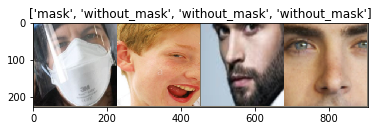

In [13]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
#Training the model


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
#Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [16]:
#Finetuning the convnet 
#Load a pretrained model and reset final fully connected layer.


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4487 Acc: 0.8292
val Loss: 0.1105 Acc: 0.9586

Epoch 1/24
----------
train Loss: 0.4387 Acc: 0.8473
val Loss: 0.3033 Acc: 0.8626

Epoch 2/24
----------
train Loss: 0.3056 Acc: 0.8876
val Loss: 0.0463 Acc: 0.9876

Epoch 3/24
----------
train Loss: 0.2736 Acc: 0.9039
val Loss: 0.0443 Acc: 0.9833

Epoch 4/24
----------
train Loss: 0.2158 Acc: 0.9235
val Loss: 0.0533 Acc: 0.9891

Epoch 5/24
----------
train Loss: 0.1384 Acc: 0.9492
val Loss: 0.0583 Acc: 0.9818

Epoch 6/24
----------
train Loss: 0.1099 Acc: 0.9616
val Loss: 0.2716 Acc: 0.8910

Epoch 7/24
----------
train Loss: 0.0977 Acc: 0.9623
val Loss: 0.0535 Acc: 0.9847

Epoch 8/24
----------
train Loss: 0.0807 Acc: 0.9706
val Loss: 0.0587 Acc: 0.9782

Epoch 9/24
----------
train Loss: 0.0704 Acc: 0.9757
val Loss: 0.0585 Acc: 0.9753

Epoch 10/24
----------
train Loss: 0.0743 Acc: 0.9721
val Loss: 0.0812 Acc: 0.9695

Epoch 11/24
----------
train Loss: 0.0741 Acc: 0.9757
val Loss: 0.0520 Acc: 0.9797

Ep

In [25]:
torch.save(model_ft, 'finetuned_model_resnet18.pth')


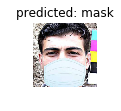

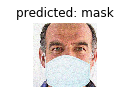

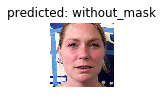

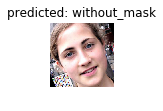

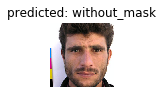

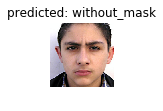

In [19]:
visualize_model(model_ft)


In [20]:
#ConvNet as fixed feature extractor (alternative)
#we need to freeze all the network except the final layer. 
#We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().


model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [21]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5347 Acc: 0.7762
val Loss: 0.1418 Acc: 0.9455

Epoch 1/24
----------
train Loss: 0.4755 Acc: 0.8085
val Loss: 0.0939 Acc: 0.9695

Epoch 2/24
----------
train Loss: 0.4552 Acc: 0.8205
val Loss: 0.1049 Acc: 0.9658

Epoch 3/24
----------
train Loss: 0.4452 Acc: 0.8288
val Loss: 0.1558 Acc: 0.9411

Epoch 4/24
----------
train Loss: 0.4523 Acc: 0.8237
val Loss: 0.1408 Acc: 0.9520

Epoch 5/24
----------
train Loss: 0.4744 Acc: 0.8270
val Loss: 0.1012 Acc: 0.9644

Epoch 6/24
----------
train Loss: 0.4605 Acc: 0.8241
val Loss: 0.0832 Acc: 0.9695

Epoch 7/24
----------
train Loss: 0.4168 Acc: 0.8506
val Loss: 0.1174 Acc: 0.9520

Epoch 8/24
----------
train Loss: 0.3397 Acc: 0.8658
val Loss: 0.0876 Acc: 0.9695

Epoch 9/24
----------
train Loss: 0.3475 Acc: 0.8553
val Loss: 0.0856 Acc: 0.9688

Epoch 10/24
----------
train Loss: 0.3419 Acc: 0.8625
val Loss: 0.0808 Acc: 0.9746

Epoch 11/24
----------
train Loss: 0.3164 Acc: 0.8683
val Loss: 0.0734 Acc: 0.9746

Ep

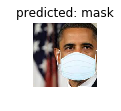

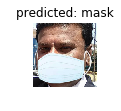

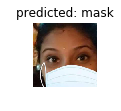

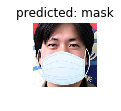

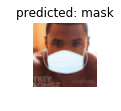

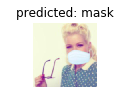

In [22]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [24]:
torch.save(model_conv, 'conv_model_resnet18.pth')


In [30]:
#Predicting the Category for all Test Images
# Confusion_matrix

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([2,2], int)
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 1376 test images: 98.91%


In [33]:
#class_wise accuracy
print('{0:5s} : {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:5s} : {1:.1f}'.format(class_names[i], r[i]/np.sum(r)*100))

Category : Accuracy
mask  : 99.1
without_mask : 98.7


In [35]:

print('actual/pred'.ljust(16), end='')
for i,c in enumerate(class_names):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(class_names[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     mask      without_mask
mask            684       6         
without_mask    9         677       


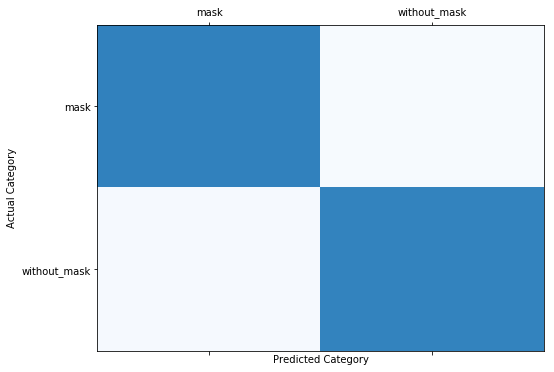

In [43]:

#plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(2), class_names)
plt.xlabel('Predicted Category')
plt.xticks(range(2), class_names)
plt.show()

In [53]:
#Predicting the Category for all Test Images
# Confusion_matrix

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([2,2], int)
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 1376 test images: 97.67%


In [54]:
#class_wise accuracy
print('{0:5s} : {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:5s} : {1:.1f}'.format(class_names[i], r[i]/np.sum(r)*100))

Category : Accuracy
mask  : 95.9
without_mask : 99.4


In [55]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(class_names):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(class_names[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     mask      without_mask
mask            662       28        
without_mask    4         682       


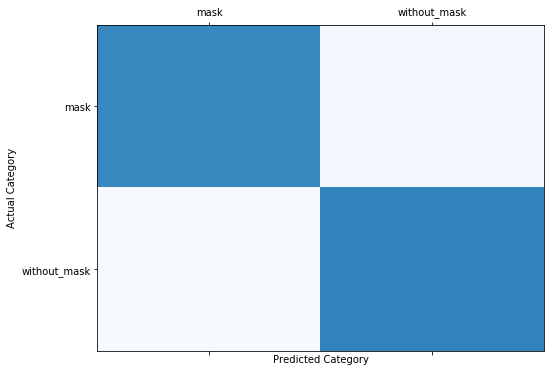

In [56]:
#plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(2), class_names)
plt.xlabel('Predicted Category')
plt.xticks(range(2), class_names)
plt.show()

In [57]:
import PIL.ImageOps
import requests
from PIL import Image

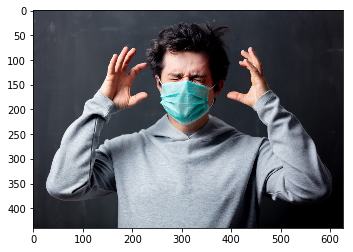

In [58]:
url = 'https://image.freepik.com/free-photo/young-white-man-protective-mask-with-headache_87910-4634.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

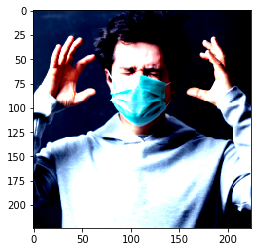

In [61]:
img = data_transforms['val'](img) 
plt.imshow(im_convert(img))

In [63]:
image = img.to(device).unsqueeze(0)
output = model_ft(image)
_, pred = torch.max(output, 1)
print(class_names[pred.item()])

mask
